## Fwrf deepnet model, 2014 imagery.rf data
Using robust validation procedure.


In [1]:
import numpy as np
import pandas as pd
import h5py
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
from glob import glob
from PIL import Image
from imagery_rf_field.src.glmd_betas import *
from os.path import join, basename
from time import time
from glob import glob
from scipy.io import loadmat
from scipy.stats import pearsonr
from hrf_fitting.src.feature_weighted_rf_models import make_rf_table,receptive_fields, model_space, prediction_menu, bigmult
from hrf_fitting.src.feature_weighted_rf_models import leave_k_out_training, split_em_up
from hrf_fitting.src.gabor_feature_dictionaries import gabor_feature_maps
from math import atan2, degrees
from IPython.display import Image as ipyImage

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X


### Step 0: load data

#### find data files

In [2]:
saving_spot = '/media/tnaselar/Data/scratch/'

####with z-score
# beta_path = '/musc.repo/Data/jesse/imagery_RF/brainthresh99_0_05_with_Zscore/betas/'
# file_exp = '%s_all_runs_BETAs_w_zscore.mat'

####withOUT z-score
beta_path = '/musc.repo/Data/jesse/imagery_RF/brainthresh99_0_05_withOUT_Zscore/betas/'
file_exp = '%s_all_runs_BETAs_no_zs.mat'
subject = 'TN'
stim_loc = '/musc.repo/mri/7T.cmrr/Presentation/imagery.rf.7T.July.2014/'
cond_file_path = '/musc.repo/Data/jesse/imagery_RF/brainthresh99_0_05_withOUT_Zscore/condit_names/%s_condit_names.mat' %(subject)
mask_path = '/media/tnaselar/Data/imagery_rf.2014/masks/%s_mask.nii.gz' %(subject)

#### load data

In [3]:
beta_df = load_betas_from_mat_file(join(beta_path,file_exp) %(subject))
mask = load_mask_from_nii(mask_path)

In [4]:
stim_df = load_stim_from_mat_file(cond_file_path,stim_loc)

In [5]:
mask = load_mask_from_nii(mask_path)

In [6]:
print 'volume dimensions: %s' %(mask.shape,)
print 'number of voxels: %d' %(np.sum(mask))

volume dimensions: (130, 130, 70)
number of voxels: 432342


#### instantiate simple class to gather all the data together

In [7]:
fMRI = imagery_rf_dataset(subject, beta_df, stim_df, mask)

#### eyeball description of each condition

In [9]:
fMRI.stim.head(72)

,run,category,object_name,location,image_name
0,1img,vehicle,fire_truck,north,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
1,1img,bird,birds,southeast,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
2,1img,few_humans,baby,east,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
3,1img,few_humans,baby,west,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
4,1img,few_humans,baby,southwest,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
5,1img,many_humans,audience,south,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
6,1img,part_of_building,building,east,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
7,1img,few_humans,baby,northeast,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
8,1img,bird,birds,southwest,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
9,1img,many_humans,audience,northeast,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...


#### look at one of the stimuli

/musc.repo/mri/7T.cmrr/Presentation/imagery.rf.7T.July.2014/imagery_005/frame_files/000718.006.02.image.png
audience
southwest


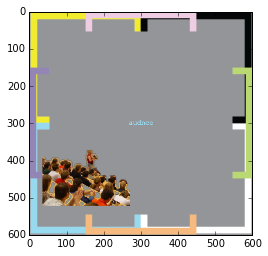

In [10]:
cond_dx = 512
img = fMRI.get_condition_stimuli(cond_dx)
plt.imshow(img)
print fMRI.stim.loc[cond_dx,'image_name']
print fMRI.stim.loc[cond_dx,'object_name']
print fMRI.stim.loc[cond_dx,'location']

#### separate out the imagery and perception indices

In [11]:
idx = {}
idx['img'] = fMRI.get_stimuli_with('run','img').index
idx['pcp'] = fMRI.get_stimuli_with('run','pcp').index


print 'number of imagery stimuli: %d' %(len(idx['img']))
print 'number of perception stimuli: %d' %(len(idx['pcp']))

number of imagery stimuli: 512
number of perception stimuli: 512


### Step 1: load up deepnet feature maps

In [13]:
deepnet_file_loc = '/media/tnaselar/Data/imagery_rf.2014/model_runs/imagery.rf.7T.July.2014/'
stim_file_template =  'imagery.rf.7T.July.2014_stimuli_*.mat'
fmap_file_template = 'imagery.rf.7T.July.2014_response_*.mat'



stim_files = sorted(glob(join(deepnet_file_loc, stim_file_template)))
fmap_files = sorted(glob(join(deepnet_file_loc,fmap_file_template)))

##don't use these...yet
junk_keys = ['__header__', '__globals__', '__version__', 'fc6', 'fc7', 'fc8','prob']

##ignore the blank stimulus
rest_frame = 'rest_frame_0.png       '


In [14]:
##get basic dimensions of feature maps
print '===============allocating memory for feature dictionary======='
feature_dict = {}
n_runs = len(stim_files)
init_fmap = loadmat(open(fmap_files[0],'r'))['respPcp']
for key in [key for key in init_fmap.dtype.fields.keys() if key not in junk_keys]:
    dims = init_fmap[key][0,0].shape
    n_stims = dims[0]-1 ##-1 for the blank image
    feature_dict[key] = np.zeros((2*n_runs*n_stims,)+dims[1:], dtype='float32')

===============allocating memory for feature dictionary=======


In [15]:
print '===feature resolutions'
for key in feature_dict.keys():
    print feature_dict[key].shape

===feature resolutions
(1024, 384, 13, 13)
(1024, 256, 27, 27)
(1024, 96, 55, 55)
(1024, 256, 13, 13)
(1024, 384, 13, 13)


In [16]:
##note we only the feature maps for the "stimPcp" case because the imagery were identical.
used_up = []
for stim_f,fmap_f in zip(stim_files,fmap_files):
    cur_stim = list(loadmat(open(stim_f, 'r'))['stimPcp'])
    cur_stim.remove(rest_frame)
    cur_fmap = loadmat(open(fmap_f, 'r'))['respPcp']
    fmap_keys = [key for key in cur_fmap.dtype.fields.keys() if key not in junk_keys]
    for ii,stim in enumerate(cur_stim):
        row_dx = fMRI.stim[fMRI.stim['image_name'].apply(basename)== stim].index.tolist()
        if not len(row_dx):
            print stim
            raise ValueError('stimulus in the deepnet list was not found in fMRI.stim database')
        if not any([True for i in row_dx if i in used_up]):
            used_up += row_dx
        else:
            raise ValueError('the current stimuli have already been assigned')
            
        for key in fmap_keys:
            feature_dict[key][row_dx,:,:,:] = cur_fmap[key][0,0][ii,:,:,:]

In [17]:
if sorted(used_up) == fMRI.stim.index.tolist():
    print '===all stimuli accounted for'
else:
    raise ValueError('not all of the stimuli have been used')

===all stimuli accounted for


#### calculate deg_per_stimulus

In [18]:
native_stim_size = 600  ##pixels
viewing_distance = 100 ##cm
viewing_area = 38.8 ##cm
deg_per_stimulus = 21.958

# Calculate the number of degrees that correspond to a single pixel. This will
# generally be a very small value, something like 0.03.
deg_per_px = degrees(atan2(.5*viewing_area, viewing_distance)) / (.5*native_stim_size)
print '%f pixels correspond to one degree' % (1./deg_per_px)
# Calculate the size of the stimulus in degrees
size_in_deg = native_stim_size * deg_per_px
print 'The size of the stimulus is %s pixels and %s visual degrees' % (native_stim_size, size_in_deg)



27.324889 pixels correspond to one degree
The size of the stimulus is 600 pixels and 21.958003465 visual degrees


### Step 2: Design receptive field grid

In [19]:
deg_per_radius = (1., 10., 4) ##rf sizes in degrees (smallest, largest, number of sizes)
spacing = 3 ##spacing between rf's in degrees
rf = receptive_fields(deg_per_stimulus,deg_per_radius,spacing)

In [20]:
rf.rf_table.deg_per_radius.unique()

array([  1.,   4.,   7.,  10.])

In [21]:
print 'G = number of rf models = %d' %(rf.rf_table.shape[0])

G = number of rf models = 196


### Step 3: Construct a model space

#### specify activation function

In [22]:
def log_act_func(x):
    return np.log(1+np.sqrt(x))

#### instantiate a model space object

In [23]:
ms = {}
ms['pcp'] = model_space(feature_dict, rf, activation_function = log_act_func)
ms['img'] = model_space(feature_dict, rf, activation_function = log_act_func)

### Step 4: train the perception and imagery models

#### train/test split

In [26]:
val_frac = 0.04687  ##24
nvox = 20000#fMRI.betas.shape[0]
n_resamples = 10 ##for a total of 240 validation samples

#### train the model!

In [27]:
state_list = ['pcp', 'img']
mst = {}
params = {}

pred = {}
val_cc = {}
val_idx = {}
trn_idx = {}
for state in state_list:
    print '==========================================================%s' %(state)
    ##build model space tensor
    params[state] = {}
    mst[state] = ms[state].construct_model_space_tensor(feature_dict, normalize=False)
    mst[state] = ms[state].normalize_model_space_tensor(mst[state],save=True)
    voxel_data = fMRI.betas[0:nvox, idx[state]].T
    val_idx[state] = split_em_up(len(idx[state]),val_frac,n_resamples)
    

    trn_idx[state], params[state] = leave_k_out_training(val_idx[state],
                                                         mst[state],
                                                         voxel_data,
                                                         initial_feature_weights='zeros',
                                                         voxel_binsize = 25000,
                                                         rf_grid_binsize=10,
                                                         learning_rate=10**(-5.),
                                                         max_iters = 50,
                                                         early_stop_fraction=0.05,
                                                         report_every = 25)
    ##generate predictions
    Tval = len(val_idx[state][0])
    pred[state] = np.zeros((Tval*n_resamples,nvox))
    val_cc[state] = np.zeros(nvox)

    for val_iter in val_idx[state].keys():
        frf = params[state][val_iter]['frf']
        ffw = params[state][val_iter]['ffw']
        
        for v in range(nvox): 
            pred[state][(val_iter*Tval):(val_iter*Tval+Tval),v] = np.squeeze(bigmult(mst[state][np.newaxis,frf[v],val_idx[state][val_iter],:],
                                           ffw[np.newaxis,:,v, np.newaxis]))
    
    total_val_idx = np.concatenate(val_idx[state].values()).astype('int')    
    for v in range(nvox): 
        val_cc[state][v] = np.nan_to_num(pearsonr(voxel_data[total_val_idx,v],pred[state][:,v])[0])


==========================================================pcp
-----------feature: conv3
at pixel resolution 13 the following rfs will default to 0: (array([ 1.]),)
-----------feature: conv2
-----------feature: conv1
-----------feature: conv5
at pixel resolution 13 the following rfs will default to 0: (array([ 1.]),)
-----------feature: conv4
at pixel resolution 13 the following rfs will default to 0: (array([ 1.]),)
converted nans to nums
model_space_tensor has been z-scored
number of validation samples: 24
number of data samples: 512
======beginning training round 0
--------------voxels from 0 to 20000
--------candiate rf models 0 to 10
-------
errors: 16702.536164
change in best rf: 87508.000000
norm of feature weights: 68.664841
improvements: 200000
6.06449198723
-------
errors: 16466.830095
change in best rf: -212.000000
norm of feature weights: 752.312866
improvements: 57404
66.0740420818
--------candiate rf models 10 to 21
-------
errors: 16663.847475
change in best rf: 108563.00

/musc.repo/Docs/tnaselar/code/Python/hrf_fitting/src/feature_weighted_rf_models.py:233: UserWarning: not saving because constants are already defined
  warn('not saving because constants are already defined')


#### save it

In [29]:

saving_place = '/media/tnaselar/Data/imagery_rf.2014/model_runs/'

for ii,state in enumerate(state_list):
    saving_file = 'model_space_'+'fwrf_deepnet_robust_'+state+'_'+subject+'.p'
    ms[state].params = params[state]
    ms[state].val_cc = val_cc[state]
    pickle.dump(ms[state], open( join(saving_place, saving_file), "wb"))

PicklingError: Can't pickle <function <lambda> at 0x7f316b8ac7d0>: it's not found as __main__.<lambda>

### Step 6: analysis

#### loss history

In [ ]:
skip = 100
for ii,state in enumerate(state_list):
    beh = params[state][0]['beh']
    plt.subplot(1,2,ii+1)
    plt.title(state)
    diff = beh[:,slice(0,-1,skip)]-beh[0,slice(0,-1,skip)]
    _=plt.plot(diff)
    plt.ylim([np.min(diff.ravel()),np.max(diff.ravel())])
plt.tight_layout()

In [ ]:
for ii,state in enumerate(state_list):
    beh = params[state][0]['beh']
    plt.subplot(1,2,ii+1)
    plt.title(state)
    _=plt.hist(np.nan_to_num(beh[0,:]-np.min(beh,axis=0)),100)
    plt.yscale('log')

#### rf's

In [ ]:
for ii,state in enumerate(state_list):
    frf = params[state][0]['frf']
    plt.subplot(1,2,ii+1)
    _=plt.hist(frf,ms[state].receptive_fields.G)
    plt.xlabel('smaller-->bigger')
    plt.title(state)

In [ ]:
for ii,state in enumerate(state_list):
    frf = params[state][0]['frf']
    plt.subplot(1,2,ii+1)
    plt.title(state)
    plt.imshow(np.sum(ms[state].receptive_fields.make_rf_stack(64, min_pix_per_radius=1)[frf,:,:], axis=0), cmap='hot')

#### prediction accuracy histograms

number of voxels with cc > 0.500000, pcp: 1
number of voxels with cc > 0.500000, img: 0


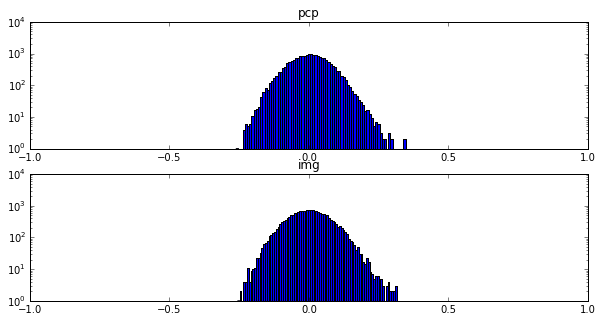

In [30]:
count_thresh = .5
plt.figure(figsize = (10,5))
for ii,state in enumerate(state_list):
    plt.subplot(2,1,ii+1)
    _=plt.hist(val_cc[state],100)
    plt.yscale('log')
    plt.ylim([10**0, 10**4])
    plt.xlim([-1, 1.])
    plt.title(state)
    print 'number of voxels with cc > %f, %s: %d' %(count_thresh,state,np.sum(map(lambda x: x > count_thresh, val_cc[state])))

In [ ]:
plt.figure(figsize = (10,5))
for ii,state in enumerate(state_list):
    values, base = np.histogram(val_cc[state], bins=100)
    #evaluate the cumulative
    cumulative = np.cumsum(values)
    # plot the cumulative function
    plt.plot(base[:-1], cumulative, hold=True,label=state, linewidth=3)#     plt.yscale('log')
#     plt.ylim([10**0, 10**4])
#     plt.xlim([-1, 1.])
    
plt.legend(loc='best')    

#### prediction accuracy head-to-head

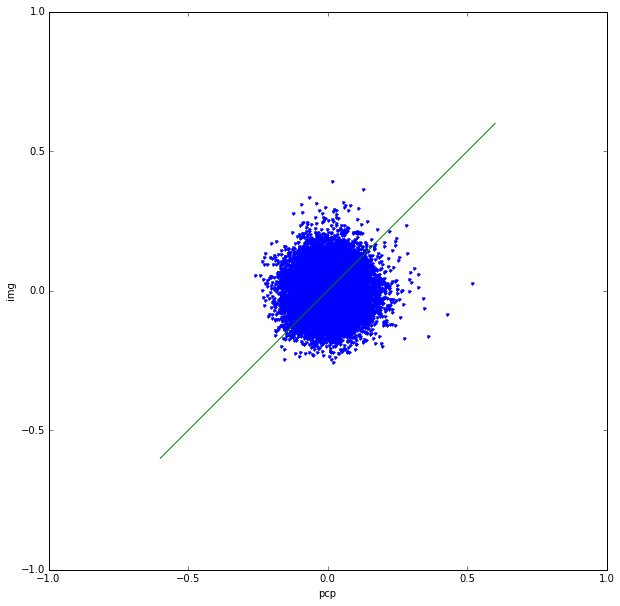

In [31]:
if ('pcp' in state_list) & ('img' in state_list):
    plt.figure(figsize=(10,10))
    rng = np.linspace(-.6, .6, num=50)
    plt.plot(val_cc['pcp'], val_cc['img'], '.');
    plt.ylabel('img')
    plt.xlabel('pcp')
    plt.plot(rng, rng)
    plt.axes().set_aspect(1)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])

#### prediction accuracy volumes

In [32]:
def view_vol_data(data_object, data_vol,save_to = None):
    cur = data_object.mask.ravel(order=data_object.order).copy()
    cur[cur > 0] = data_vol
    view_vol = cur.reshape(data_object.shape,order=data_object.order)
    if save_to:
        nib.save(nib.Nifti1Image(view_vol,affine=np.eye(4)),save_to)
    else:
        return view_vol

In [33]:
for state in state_list:
    view_vol_data(fMRI,val_cc[state], save_to = '/media/tnaselar/Data/scratch/deepnet_'+state+'_val_cc_'+subject )

ValueError: NumPy boolean array indexing assignment cannot assign 20000 input values to the 432342 output values where the mask is true